This notebook helps to learn how to build a basic image classification system from scratch, and progressively improve it using higher levels of abstraction and finally using the learner module in fastai. We choose a problem that is similar to MNIST digit classification, but slightly different to allow a deeper understanding of building an end-to-end solution on a "not-so-familiar" dataset. The model has to classify handwritten music symbol image into one of the 5 classes namely whole note, half note, quarter note, eighth note and sixteenth note. 

In [1]:
from fastai.vision.all import *
from fastbook import *

In [2]:
dataset_path = Path('/home/jobin/exploration/datasets/NotesDataset/Notes')

In [3]:
## start with simple problem => 2 class problem to differentiate half note from quarter note ##
quarters = (dataset_path/'Quarter').ls().sorted()
halfs = (dataset_path/'Half').ls().sorted()

In [4]:
quarters[0],halfs[0]

(Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Quarter/q1.jpg'),
 Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h1.jpg'))

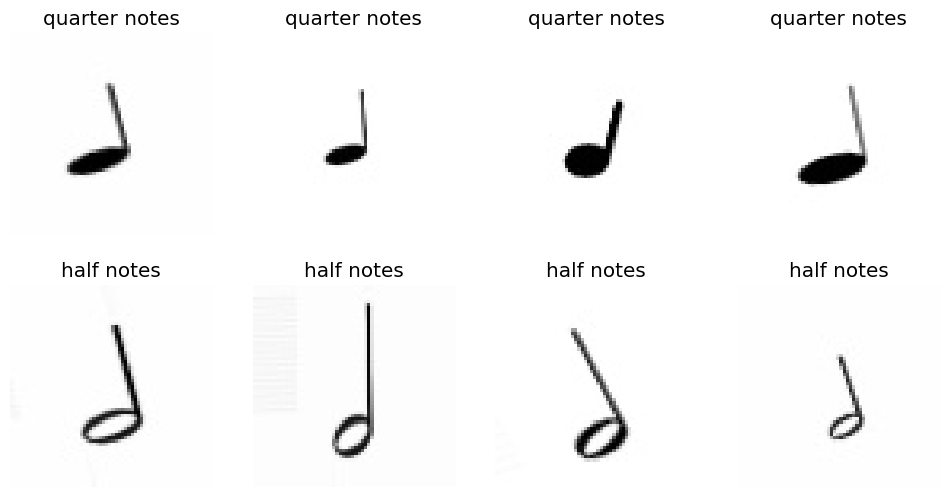

In [5]:
## show some samples
_,axs = plt.subplots(nrows=2,ncols=4, figsize=(12,6))
for i in range(4):
    show_image(Image.open(quarters[i]),title='quarter notes',ax=axs[0][i])
    show_image(Image.open(halfs[i]),title='half notes',ax=axs[1][i])

In [6]:
## load into a tensor and see how it looks ##
quarter_tens = tensor(Image.open(quarters[0]).convert('L')) ## convert to grey scale - original has RGB 
quarter_tens.shape ## each input is now a 64X64 grey-scale image

torch.Size([64, 64])

In [7]:
## plot a portion ##
df = pd.DataFrame(quarter_tens[15:55,15:45])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,254,254,254,254,254,254,254,254,254,254,255,254,253,253,253,248,242,253,253,253,254,254,254,254,254,254,254,254,254,254
1,254,254,254,254,254,254,254,254,254,254,254,254,251,254,252,198,132,206,252,254,253,251,255,254,254,254,254,254,254,254
2,254,254,254,254,254,254,254,254,254,255,255,254,255,254,244,184,74,136,251,255,255,255,253,254,255,254,254,254,254,254
3,254,254,254,254,254,254,254,254,254,253,253,251,254,254,255,224,89,76,255,254,250,254,255,255,252,254,254,254,254,254
4,254,254,254,254,254,254,254,254,254,255,255,255,253,251,254,245,115,46,237,254,254,252,255,253,255,254,254,254,254,254
5,254,254,254,254,254,254,254,254,254,253,254,255,255,255,255,252,150,58,184,252,255,255,254,251,255,254,254,254,254,254
6,254,254,254,254,254,254,254,254,254,254,254,253,251,253,252,250,192,80,123,255,253,255,252,254,253,254,254,254,254,254
7,254,254,254,254,254,254,254,254,254,253,255,254,255,255,253,253,230,91,71,252,255,253,253,255,255,254,254,254,254,254
8,254,254,254,254,254,254,254,254,254,253,255,251,254,253,253,255,248,123,45,227,253,252,255,251,254,254,254,254,254,254
9,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,253,252,158,66,171,252,255,252,255,254,254,254,254,254,254


## approach-1 => simple pattern matching ##
1. load all half-notes into a tensor and calculate "avergae" half-note image
2. Load all quarter-notes into a tensor and calculate "avergae" quarter-note image
3. for any incoming image, check distance between the "average" images and predict the class as the one corresponding to the one which is "closer"

In [8]:
half_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in halfs])/255.0
quarter_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in quarters])/255.0

In [9]:
half_tensor.shape,quarter_tensor.shape

(torch.Size([1000, 64, 64]), torch.Size([1000, 64, 64]))

<Axes: title={'center': 'quarter'}>

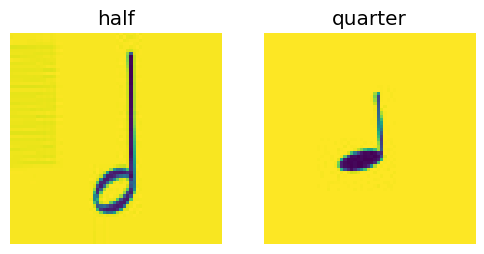

In [10]:
## show some plot of single channel image
_,axs = plt.subplots(nrows=1,ncols=2,figsize=(6,3))
show_image(half_tensor[1],title='half',ax=axs[0])
show_image(quarter_tensor[1],title='quarter',ax=axs[1])

In [11]:
mean_halfnote = half_tensor.mean(dim=0)
mean_quarternote = quarter_tensor.mean(dim=0)

<Axes: title={'center': 'mean quarter-note'}>

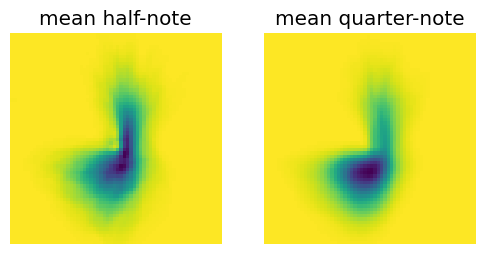

In [12]:
_,axs = plt.subplots(1,2,figsize=(6,3))
show_image(mean_halfnote,title='mean half-note',ax=axs[0])
show_image(mean_quarternote,title='mean quarter-note',ax=axs[1])

In [13]:
query_image = quarter_tensor[-1]

In [14]:
## compute l1-distance between query image and mean image, and predict the class ##
F.l1_loss(query_image,mean_quarternote),F.l1_loss(query_image,mean_halfnote)

(tensor(0.0594), tensor(0.0634))

In [15]:
def is_quarter_note(img_tensor):
    return F.l1_loss(img_tensor,mean_quarternote) < F.l1_loss(img_tensor,mean_halfnote)

In [16]:
is_quarter_note(query_image)

tensor(True)

### evaluate the baseline in a formal way ###
1. split data into train and test
2. learn the "mean" images from train split
3. use the classification function is_quarter_note to calculate accuracy

In [17]:
train_split_percent = 0.8
train_halfnote_x = half_tensor[:int(len(half_tensor)*train_split_percent)]
valid_halfnote_x = half_tensor[int(len(half_tensor)*train_split_percent):]

train_quarternote_x = quarter_tensor[:int(len(quarter_tensor)*train_split_percent)]
valid_quarternote_x = quarter_tensor[int(len(quarter_tensor)*train_split_percent):]

In [18]:
train_halfnote_x.shape,train_quarternote_x.shape,valid_halfnote_x.shape,valid_quarternote_x.shape

(torch.Size([800, 64, 64]),
 torch.Size([800, 64, 64]),
 torch.Size([200, 64, 64]),
 torch.Size([200, 64, 64]))

In [19]:
mean_quarternote = train_quarternote_x.mean(0)
mean_halfnote = train_halfnote_x.mean(0)

In [20]:
def image_distance(a,b): 
    return (a-b).abs().mean((-1,-2))

def is_quarter_note(img_tensor):
    return image_distance(img_tensor,mean_quarternote) < image_distance(img_tensor,mean_halfnote)

In [21]:
accuracy_quarter = is_quarter_note(valid_quarternote_x).float() .mean()
accuracy_half = (1.0 - is_quarter_note(valid_halfnote_x).float()).mean()

In [22]:
print(f'accuracy of quarter note={accuracy_quarter},accuracy of half note={accuracy_half},\
overall acc={(accuracy_quarter+accuracy_half)/2}')

accuracy of quarter note=0.29499998688697815,accuracy of half note=1.0,overall acc=0.6474999785423279


In [23]:
## 64.7 is not a very great accuracy;especially it cannot recognize quarter notes correctly##


### lets try an off-the-shelf vision learner from fastai to see what is possible ##
1. simply load images from two directories using a fastai dataloader
2. use a vision learner and a pretrained off-the-shelf model like resnet
3. see what kind of accuracy can be obtained by simple finetuning (note data is loaded as RGB in this case)

In [25]:
## prepare a dataloader#
dataset_path

Path('/home/jobin/exploration/datasets/NotesDataset/Notes')

In [26]:
classes = ['Quarter','Half']

In [27]:
dataset_path.ls()

(#5) [Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Quarter'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Eight'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Sixteenth'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Whole'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half')]

In [37]:
## selectively filter only two classes as we want to model this first as a binary classification problem ##
def filter_items_from_folders(path,folders):
    return get_image_files(path).filter(lambda x:x.parent.name in folders)

In [43]:
lst = filter_items_from_folders(dataset_path,classes)
print(f'total files={len(lst)}')

total files=2000


In [51]:
dls = ImageDataLoaders.from_lists(dataset_path, 
                                  fnames=quarters+halfs,
                                  labels = ['Quarter']*len(quarters) + ['Half']*len(halfs),
                                  valid_pct = 0.2,
                                  seed = 42
                                  )                                     

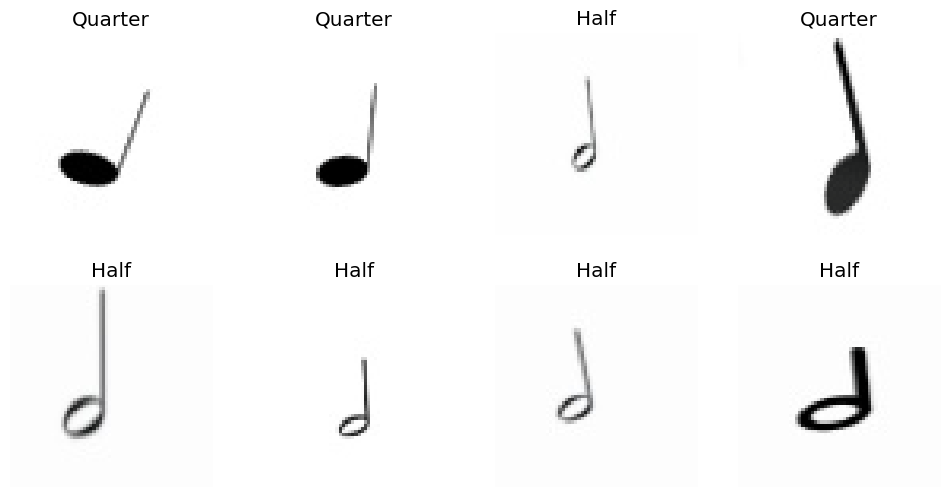

In [56]:
dls.show_batch(nrows=2,ncols=4)

In [53]:
learner = vision_learner(dls,resnet18,loss_func=F.cross_entropy,metrics=accuracy)

In [54]:
learner.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.512877,0.274359,0.900000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.080464,0.093742,0.970000,00:01
1,0.038653,0.035848,0.992500,00:01
2,0.028030,0.003805,1.000000,00:01


### this means an off-the-shelf vision model can easily solve this task ###
Why did our baseline work very poorly?
1. we combined RGB channels into one to create 64x64 images while loading data in the baseline => information loss?
2. pretrained resent is quite powerful in its feature extraction already..so classifying these images is quite an easy task for the model